W niniejszym ćwiczeniu zostanie użyty algorytm śledzenia z rodziny filtrów korelacyjnych. W algorytmach tych wykorzystywany jest pewien filtr za pomocą którego zamodelowany jest śledzony obiekt. W celu predykcji nowego położenia obiektu, dokonywana jest korelacja obszaru śledzenia z filtrem. Obliczenia wykonywane są w dziedzinie częstotliwości, ponieważ szybciej jest obliczyć transformatę Fouriera za pomocą algorytmu FFT (*Fast Fourier Transform*) i skorzystać z twierdzenia o konwolucji, niż obliczać korelację wprost. Algorytmy śledzenia z rodziny filtrów korelacyjnych cechuje niska złożoność obliczeniowa (czyli możliwe jest śledzenie w czasie rzeczywistym) przy zachowaniu konkurencyjnej jakości śledzenia.

W dzisiejszym ćwiczeniu wykorzystana zostanie najprostsza wersja algorytmu opisana w publikacji:
https://www.cs.colostate.edu/~draper/papers/bolme_cvpr10.pdf

W pierwszej klatce obrazu filtr jest inicjalizowany na podstawie fragmentu obrazu w skali szarości $f$, który zawiera obiekt do śledzenia.

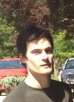

$H^*_t = \frac{A}{B}$

$A = \sum^N_i G_i \odot F^*_i$        (1a)

$B = \sum^N_i F_i \odot F^*_i$        (1b)

gdzie $F_i$ jest dyskretną transformatą Fouriera fragmentu obrazu $f_i$, natomiast $G$ jest transformatą Fouriera dwuwymiarowego rozkładu Gaussa $g$ o rozmiarze śledzonego obszaru: 

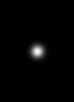

Działanie $\odot$ oznacza mnożenie typu element przez element, a $X^*$ oznacza sprzężenie zespolone (wynikiem transformacji Fouriera są liczby zespolone).

Suma po $i$ oznacza, że z jednej próbki obiektu w pierwszej klatce śledzenia należy utworzyć zbiór $N$ próbek uczących składających się z losowych rotacji próbki bazowej:

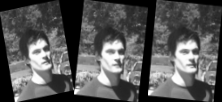

Następnie, w każdej klatce obrazu dokonywana jest predykcja położenia:

$\mathcal{F^{-1}}\{ F \odot H^* \}$      (2)

gdzie $\mathcal{F^{-1}}$ oznacza odwrotną, dyskretną transformację Fouriera, natomiast $F$ jest tutaj transformatą fragmentu obrazu scentrowanego na ostatnio znanej pozycji obiektu. Otrzymana w ten sposób mapa korelacji reprezentuje przewidziane prez filtr przesunięcie obiektu względem poprzedniej klatki obrazu:

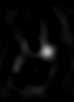

Po każdej predykcji, filtr jest aktualizowany fragmentem aktualnej klatki obrazu wyciętym na nowej pozycji obiektu:

$A_t = \eta G \odot F^*_t + (1-\eta) A_{t-1}$       (3a)

$B_t = \eta F_t \odot F^*_t + (1-\eta) B_{t-1}$     (3b)

Gdzie $\eta \in [0, 1]$ jest przyjętym współczynnikiem uczenia.

Na początek zaimportujmy potrzebne biblioteki i zadeklarujmy parametry algorytmu:

In [1]:
# from google.colab import drive
import numpy as np
import cv2
# from google.colab.patches import cv2_imshow
import imutils
import os
from os.path import join

# drive.mount('/content/gdrive')
# DATASET_DIR = '/content/gdrive/My Drive/Dydaktyka/ZAW/CF/sequences'

SIGMA = 17
SEARCH_REGION_SCALE = 2
LR = 0.125
NUM_PRETRAIN = 128
VISUALIZE = True

Ćwiczenie przeprowadzone będzie z użyciem sekwencji ze zbioru VOT2013

Pomocnicze funkcje do czytania pliku zawierającego pozycje obiektu i wizualizacji zbioru:

In [2]:
def load_gt(gt_file):

    with open(gt_file, 'r') as file:
        lines = file.readlines()

    lines = [line.split(',') for line in lines]
    lines = [[int(float(coord)) for coord in line] for line in lines]
    # returns in x1y1wh format
    return lines


def show_sequence(sequence_dir):

    imgdir = join(sequence_dir, 'color')
    imgnames = os.listdir(imgdir)                  
    imgnames.sort()
    gt_boxes = load_gt(join(sequence_dir, 'groundtruth.txt'))

    for imgname, gt in zip(imgnames, gt_boxes):
        img = cv2.imread(join(imgdir, imgname))
        position = [int(x) for x in gt]
        cv2.rectangle(img, (position[0], position[1]), (position[0]+position[2], position[1]+position[3]), (255, 0, 0), 2)
        cv2.imshow('demo', img)
        if cv2.waitKey(0) == ord('q'):
            break

        # cv2_imshow(img)


In [30]:
# DATASET_DIR = 'sequences/sequences'
# show_sequence(join(DATASET_DIR, 'jump'))

Na początek warto zaimplementować funkcję, która przyjmując klatkę obrazu oraz pozycję obiektu, zwróci fragment obrazu w skali szarości zawierający śledzony obiekt. Przyjmijmy, że położenie obiektu przekazywane jest w formacie $[x_1, y_1, w, h]$ ($x_1$, $y_1$) - lewy-górny punkt prostokąta otaczającego; $w$, $h$ - szerokość i wysokość).

Do śledzenia szybkich obiektów przydatnym jest uwzględniać nieco większy obszar scentrowany na pozycji obiektu, `SEARCH_REGION_SCALE` razy szerszy i wyższy niż sam obiekt.

🔔 **TODO (1)** zmodyfikować wartości `xmin, xmax, ymin, ymax` tak, aby obejmowały szerszy kontekst obrazu - wykorzystać zadeklarowany parametr `SEARCH_REGION_SCALE`.

🔔 **TODO (2)** Zabezpieczyć algorytm przed wykraczaniem obszaru poszukiwań poza kadr poprzez zastosowanie paddingu wejściowej klatki obrazu (przydatna funkcja: `frame = cv2.copyMakeBorder(frame, y_pad, y_pad, x_pad, x_pad, cv2.BORDER_REFLECT)` - padding przyjąć przynajmniej o rozmiarze obszaru poszukiwania). Należy pamiętać o tym, że współrzędne punktów na oryginalnym obrazie powinny zostać odpowiednio skorygowane o padding.

Warto przetestować zaimplementowaną funkcję poprzez wyświetlenie uzyskanego obszaru.

In [3]:

def crop_search_window(bbox, frame):

    xmin, ymin, width, height = bbox
    xmax = xmin + width
    ymax = ymin + height

    #----TODO (1)
    x_offset = (width * SEARCH_REGION_SCALE - width) / 2
    y_offset = (height * SEARCH_REGION_SCALE - height) / 2
    xmin = xmin - x_offset
    xmax = xmax + x_offset
    ymin = ymin - y_offset
    ymax = ymax + y_offset
    #----TODO (1)

    #----TODO (2)
    y_pad = int(ymax-ymin) 
    x_pad = int(xmax-xmin) 

    frame = cv2.copyMakeBorder(frame, y_pad, y_pad, x_pad, x_pad, cv2.BORDER_REFLECT)
    xmin += x_pad
    xmax += x_pad
    ymin += y_pad
    ymax += y_pad
    #----TODO (2)

    window = frame[int(ymin) : int(ymax), int(xmin) : int(xmax), :]


    cv2.imshow('search window', window.astype(np.uint8))
    
    window = cv2.cvtColor(window, cv2.COLOR_BGR2GRAY)
    # print("WINDOW:", window.shape)
    return window


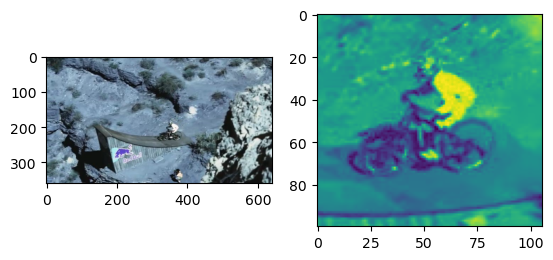

In [4]:
import matplotlib.pyplot as plt
DATASET_DIR = 'sequences\\sequences'

img = cv2.imread('C:\\Users\\Krzysztof_Gora\\University\\ZAW\\lab7\\sequences\\sequences\\jump\\color\\00000001.jpg')
sequence = 'jump'
seqdir = join(DATASET_DIR, sequence)
gt_boxes = load_gt(join(seqdir, 'groundtruth.txt'))
position = gt_boxes[0]

img_crop = crop_search_window(position, img)
f, ax = plt.subplots(1, 2)
ax[0].imshow(img)
ax[1].imshow(img_crop)
plt.show()


Przydatna będzie funkcja generująca dwuwymiarowy rozkład Gaussa - kluczowe jest, aby ta funkcja oraz powyższa zwracały macierz o takich samych rozmiarach dla danego obiektu.

In [4]:
def get_gauss_response(gt_box):

    width = gt_box[2] * SEARCH_REGION_SCALE
    height = gt_box[3] * SEARCH_REGION_SCALE
    xx, yy = np.meshgrid(np.arange(width), np.arange(height))

    center_x = width // 2
    center_y = height // 2
    dist = (np.square(xx - center_x) + np.square(yy - center_y)) / (2 * SIGMA)
    response = np.exp(-dist)

    return response

Przed obliczeniem transformaty Fouriera, fragment obrazu należy odpowiednio przygotować.

🔔 **TODO (3)**
Proszę uzupełnić funkcję, która dokona preprocessingu wejściowego fragmentu obrazu w skali szarości:
- transformacja funkcją logarytm (warto dodać 1 do każdego piksela, aby uniknąć logarytmowania zera) - funkcja `np.log()`
- normalizacja (odjęcie wartości średniej i podzielenie przez odchylenie standardowe) - funkcje `np.mean()`, `np.std()`

Przemnożenie przez dwuwymiarowe okno Hanninga zostało zaimplementowane korzystając z funkcji `np.hanning()` generującą dyskretne, jednowymiarowe okno o zadanej szerokości. 

In [5]:
def pre_process(img):

    height, width = img.shape
    img = img.astype(np.float32)

    #---- TODO (3)
    img = np.log(img + 1)
    img -= np.mean(img)
    img /= np.std(img)
    #---- TODO(3)

    #2d Hanning window
    win_col = np.hanning(width)
    win_row = np.hanning(height)
    mask_col, mask_row = np.meshgrid(win_col, win_row)
    window = mask_col * mask_row
    img = img * window

    return img

Do inicjalizacji należy wygenerować losowe próbki uczące. Do tego posłuży funkcja `random_warp`.

🔔 **TODO (4)** Proszę zaimplementować funkcję, która dokona losowej rotacji wejściowego fragmentu obrazu.
- wygenerować losowy kąt w zakrecie -+15 stopni (wykorzystać `np.random.uniform()` )
- obrócić obrazek o wylosowany kąt (funkcja `img_rot = imutils.rotate_bound(img, angle)` )
- przeskalować obrócony obrazek do oryginalnych rozmiarów wejściowego obrazka (funkcja `cv2.resize()` )

Funkcję również warto przetestować wizualnie przy użyciu funkcji `cv2.imshow()`. W przypadku problemów/wątpliwości zadanie można wykonać na koniec, algorytm powinien do pewnego stopnia zadziałać dla inicjalizacji tylko jedną próbką bazową.

In [6]:
def random_warp(img):

    #---TODO (4)
    angle = np.random.uniform(-15, 15)
    img_rot = imutils.rotate_bound(img, angle)
    img_resized = cv2.resize(img_rot, (img.shape[1], img.shape[0]))

    return img_resized

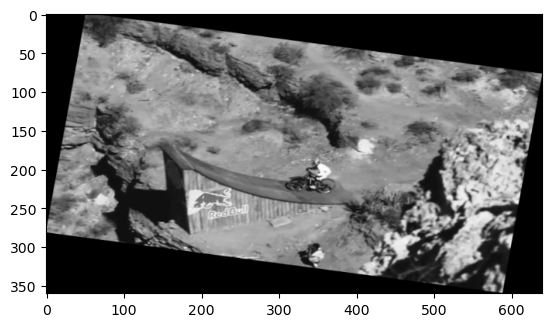

In [8]:
img = cv2.imread('C:\\Users\\Krzysztof_Gora\\University\\ZAW\\lab7\\sequences\\sequences\\jump\\color\\00000001.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = random_warp(img)

import matplotlib.pyplot as plt
plt.imshow(img, 'gray')

Poniżej przedstawiono implementację inicjalizacji na podstawie pierwszej klatki obrazu i pierwszej pozycji obiektu. Przed realizacją równań $(1a, 1b)$
, funkcja `pre_training()` wydobywa fragment obrazu, dokonuje preprocessingu i oblicza transformatę $F_i$ za pomocą zaimplementowanych wcześniej funkcji.
Wykorzystywana jest funkcja `np.fft.fft2()` realizująca algorytm FFT oraz `np.conjugate()` obliczająca sprzężenie zespolone.

Jeżeli funkcja `random_warp()` nie jest zaimplementowana, pierwsze eksperymenty należy przeprowadzić dla `NUM_PRETRAIN = 0`.


In [7]:
def initialize(init_frame, init_gt):

    g = get_gauss_response(init_gt)
    G = np.fft.fft2(g)
    Ai, Bi = pre_training(init_gt, init_frame, G)

    return Ai, Bi, G


def pre_training(init_gt, init_frame, G):

    template = crop_search_window(init_gt, init_frame)
    fi = pre_process(template)
    

    Ai = G * np.conjugate(np.fft.fft2(fi))                # (1a)
    Bi = np.fft.fft2(fi) * np.conjugate(np.fft.fft2(fi))  # (1b)

    for _ in range(NUM_PRETRAIN):
        fi = pre_process(random_warp(template))

        Ai = Ai + G * np.conjugate(np.fft.fft2(fi))               # (1a)
        Bi = Bi + np.fft.fft2(fi) * np.conjugate(np.fft.fft2(fi)) # (1b)

    return Ai, Bi

Niżej zaimplementowana funkcja `track()` przedstawia wysokopoziomowo jedną iterację działania algorytmu śledzenia. Przyjmuje ona aktualne parametry filtru oraz aktualną pozycję obiektu (w drugiej klatce śledzenia będą to parametry uzyskanie z inicjalizacji oraz pozycja startowa obiektu) i zwraca obliczoną pozycję oraz zaktualizowany filtr.

In [8]:
def track(image, position, Ai, Bi, G):

    response = predict(image, position, Ai/Bi)
    new_position = update_position(response, position)
    newAi, newBi = update(image, new_position, Ai, Bi, G)

    return new_position, newAi, newBi

🔔 **TODO (5)** W oparciu o schemat działania funkcji `track()`, proszę zaimplementować brakujące funkcje:
- `predict()` realizującą równanie $(2)$, czyli odpowiedź filtru,
- `update()` realizującą równania $(3a, 3b)$,

Analogicznie do funkcji `pre_training()`, należy na sam początek wykorzystać funkcję `crop_search_window()` do wycięcia odpowiedniego fragmentu obrazu oraz funkcję `pre_process()` do wstępnej obróbki tego fragmentu.

Do wyznaczenia odwrotnej transformaty Fouriera w funkcji `predict()` proszę wykorzystać funkcję `np.fft.ifft2()`. Funkcja `predict()` powinna zwracać macierz rzeczywistą, dlatego proszę użyć funkcji `np.real()` przed zwróceniem ostatecznej wartości.

W funkcji `update()` proszę wykorzystać parametr `LR` będący współczynnikiem uczenia przy aktualizacji filtru.

🔔 **TODO (6)** Pozostało jeszcze zaimplementować funkcję `update_position()`, która przyjmując odpowiedź filtru, zwróci nową pozycję obiektu.

- należy wyznaczyć współrzędne elementu o największej wartości (podpowiedź: funkcja `np.max(response)` zwraca maksymalną wartość macierzy `response`, a funkcja `np.where(response == max_val)` zwraca indeks macierzy `response`, który ma wartość `max_val`)
- może się zdarzyć, że więcej niż jeden indeks będzie miał wartość maksymalną - aby się przed tym zabezpieczyć można uwzględniać tylko pierwszy indeks zwrócony przez `np.where()` lub jeszcze lepiej - obliczyć średni indeks (`np.mean()`),
- przesunięcie maksymalnej wartości od środka odpowiedzi filtru jest przewidzianym przesunięciem położenia obiektu - należy zmodyfikować pierwszą i drugą współrzędną położenia (zmiany w szerokości i wysokości obiektu ignorujemy w tym ćwiczeniu).

In [28]:
def predict(frame, position, H):

    #----TODO (5)
    template = crop_search_window(position, frame)
    fi = pre_process(template)

    F = np.fft.fft2(fi)  

    out = np.fft.ifft2(F*H)
    gi = np.real(out)

    return gi


def update(frame, position, Ai, Bi, G):

    #----TODO (5)
    template = crop_search_window(position, frame)
    fi = pre_process(template)
    
    F = np.fft.fft2(fi)
    Fs = np.conjugate(F)

    Ai = LR*G*Fs + (1-LR)*Ai
    Bi = LR*F*Fs + (1-LR)*Bi

    return Ai, Bi


def update_position(spatial_response, position):

    #----TODO (6)
    id = list(np.unravel_index(spatial_response.argmax(), spatial_response.shape))

    id[0] -= spatial_response.shape[0] // 2
    id[1] -= spatial_response.shape[1] // 2
    
    new_position = position
    new_position[0] += id[1]
    new_position[1] += id[0]

    return new_position


Zaimplementowany system proszę przetestować poprzez prostą metrykę będącą średnim IoU w każdej klatce śledzenia

(dać te gotowe funkcje lub kazać samemu to zrobić)
(w folderze są sekwencje jump - prostsza, sunshade - trudniejsza)

In [11]:

def bbox_iou(box1, box2):

    # Transform from center and width to exact coordinates
    b1_x1, b1_x2 = box1[0], box1[0] + box1[2]
    b1_y1, b1_y2 = box1[1], box1[1] + box1[3]
    b2_x1, b2_x2 = box2[0], box2[0] + box2[2]
    b2_y1, b2_y2 = box2[1], box2[1] + box2[3]

    # get the corrdinates of the intersection rectangle
    inter_rect_x1 = max(b1_x1, b2_x1)
    inter_rect_y1 = max(b1_y1, b2_y1)
    inter_rect_x2 = min(b1_x2, b2_x2)
    inter_rect_y2 = min(b1_y2, b2_y2)
    # Intersection area
    inter_area = np.clip(inter_rect_x2 - inter_rect_x1, a_min=0, a_max=None) * np.clip(inter_rect_y2 - inter_rect_y1, a_min=0, a_max=None)
    # Union Area
    b1_area = (b1_x2 - b1_x1) * (b1_y2 - b1_y1)
    b2_area = (b2_x2 - b2_x1) * (b2_y2 - b2_y1)

    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)

    return iou


def test_sequence(DATASET_DIR, sequence):

    seqdir = join(DATASET_DIR, sequence)
    imgdir = join(seqdir, 'color')
    imgnames = os.listdir(imgdir)                  
    imgnames.sort()

    print('init frame:', join(imgdir, imgnames[0]))
    init_img = cv2.imread(join(imgdir, imgnames[0]))
    gt_boxes = load_gt(join(seqdir, 'groundtruth.txt'))
    position = gt_boxes[0]
    Ai, Bi, G = initialize(init_img, position)

    if VISUALIZE:
        cv2.rectangle(init_img, (position[0], position[1]), (position[0]+position[2], position[1]+position[3]), (255, 0, 0), 2)
        cv2.imshow('demo', init_img)
        cv2.waitKey(10)
        # cv2_imshow(init_img)

    results = []
    for imgname in imgnames[1:]:
        img = cv2.imread(join(imgdir, imgname))
        position, Ai, Bi = track(img, position, Ai, Bi, G)
        results.append(position.copy())

        if VISUALIZE:
            position = [round(x) for x in position]
            cv2.rectangle(img, (position[0], position[1]), (position[0]+position[2], position[1]+position[3]), (255, 0, 0), 2)
            cv2.imshow('demo', img)
            if cv2.waitKey(10) == ord('q'):
                break
            # cv2_imshow(img)

    return results, gt_boxes


In [29]:

# DATASET_DIR = '/content/gdrive/My Drive/Dydaktyka/ZAW/CF/sequences'
DATASET_DIR = 'sequences\\sequences'

# sequences = os.listdir(DATASET_DIR)
sequences = ['jump']
ious_per_sequence = {}
for sequence in sequences:

    results, gt_boxes = test_sequence(DATASET_DIR, sequence)
    ious = []
    for res_box, gt_box in zip(results, gt_boxes[1:]):
        iou = bbox_iou(res_box, gt_box)
        ious.append(iou)

    ious_per_sequence[sequence] = np.mean(ious)
    print(sequence, ':', np.mean(ious))

print('Mean IoU:', np.mean(list(ious_per_sequence.values())))

init frame: sequences\sequences\jump\color\00000001.jpg
jump : 0.5892178785443289
Mean IoU: 0.5892178785443289
